**«Сингулярный спектральный анализ»**

**Задание**

Проведите анализ с помощью SSA в любом из временных рядов с первого занятия.
При желании можете воспользоваться своим временным рядом — работа, Kaggle и т. д.

Посмотрите на результаты с разными длинами окон.

Обязательно визуализируйте результаты аналогично материалу с занятия.

**Исследуемый временной ряд - продажи компании Х  ("monthly-sales-of-company-x-jan-6.csv").**

Установка необходимых библиотек и модулей:

In [130]:
import pandas as pd
import numpy as np

# from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

Загрузка исследуемого временного ряда и его визуализация:

In [131]:
series = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")['Count']

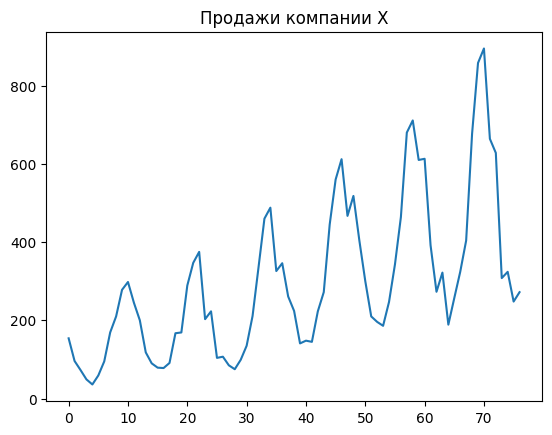

In [132]:
plt.plot(series)
plt.title('Продажи компании Х')
plt.show()

Реализация класса SSA:

In [133]:
class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.

        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """

        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)


In [134]:
len(series) # длина N временного ряда

77

Выполним SSA временного ряда с разными значениями окна L. Т.к. размер исследуемого ряда небольшой (77), значения L выберем равными 2, 5, 10 и 30.

Для наглядности сравним графики компонент и корреляционные матрицы.

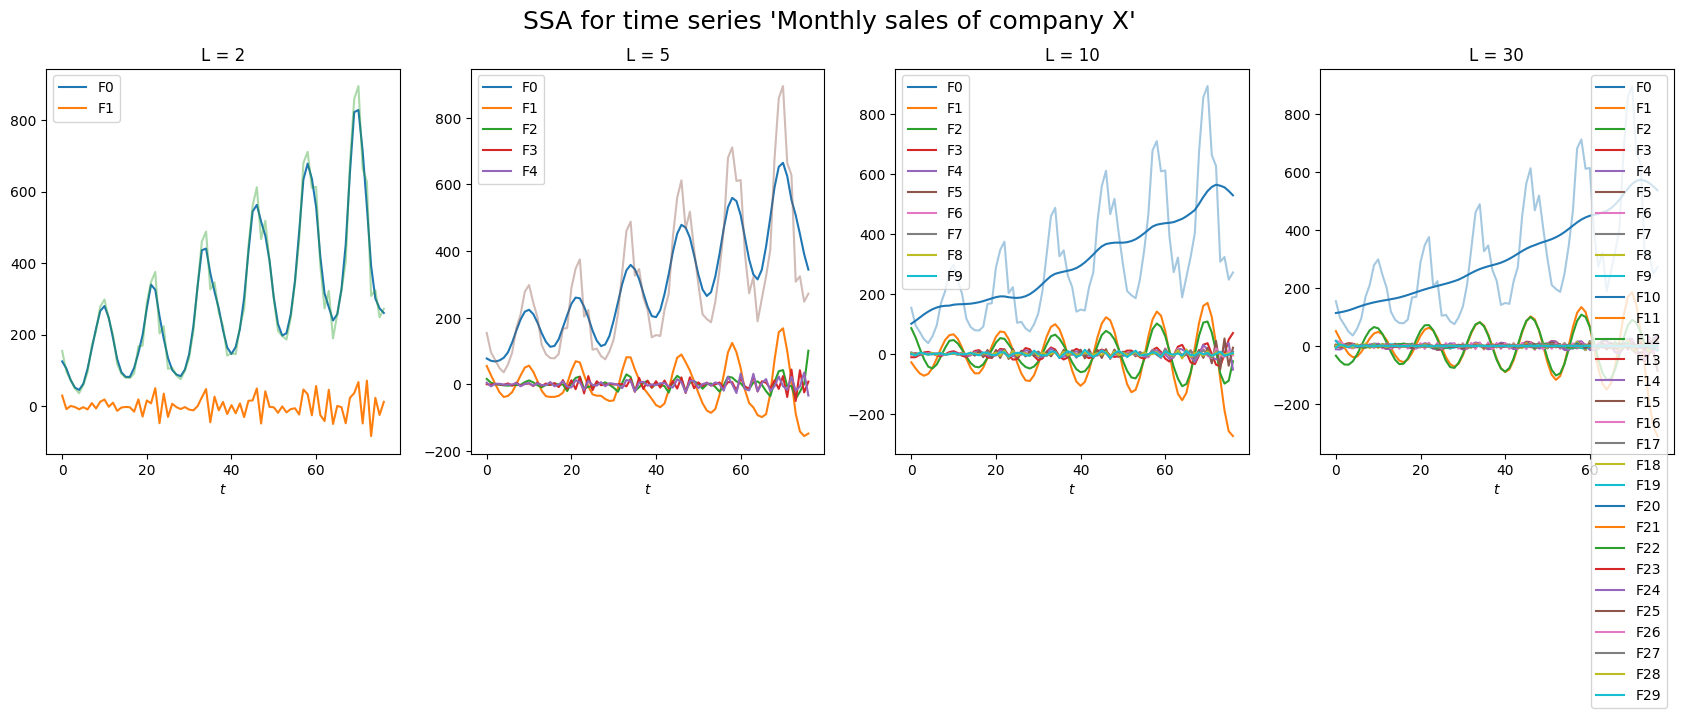

In [135]:
plt.figure(figsize=(21, 5))
plt.suptitle("SSA for time series 'Monthly sales of company X' ", fontsize=18, y=0.95, va='bottom')
l = [2, 5, 10, 30]

for n, l in enumerate(l):
  ssa_l = SSA(series, l)
  ax = plt.subplot(1, 4, n + 1)
  ssa_l.components_to_df().plot(ax=ax)
  ssa_l.orig_TS.plot(alpha=0.4)
  ax.set_title(f'L = {l}')
  ax.set_xlabel("$t$")

Размера окна, равного 2, ожидаемо не хватило для анализа, отделить удалось только шум.

При L = 10 все компоненты исследуемого ряда разделены довольно качественно: выделен восходящий тренд, две сезонности и шум (от данного размера окна можно отталкиваться, чтобы найти оптимальный).

Значение L = 30 избыточно, т.к. увеличено количество составляющих шума, значение L = 5 недостаточно, т.к. тренд не отделен.

На компонентах, представляющих сезонности, заметно присутствие гетероскедастичности, характерное для исследуемого ряда.

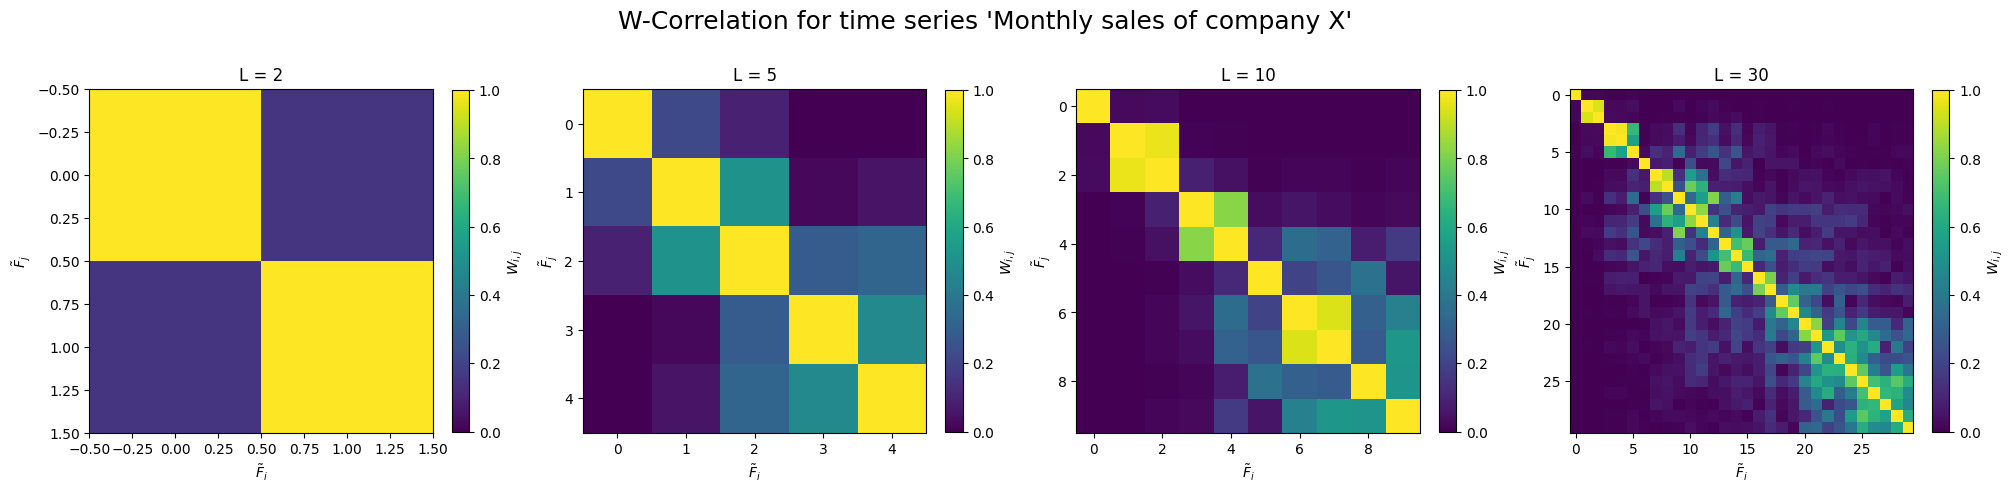

In [136]:
plt.figure(figsize=(24, 5))
plt.subplots_adjust(wspace=0.3)
plt.suptitle("W-Correlation for time series 'Monthly sales of company X' ", fontsize=18, y=0.95, va='bottom')
l = [2, 5, 10, 30]

for n, l in enumerate(l):
  ssa_l = SSA(series, l)
  ax = plt.subplot(1, 4, n + 1)
  ssa_l.plot_wcorr()
  ax.set_title(f'L = {l}')

Матрицы корреляции подтверждают выводы выше. При L = 30 сильное зашумление начинается с 9 компоненты.

При L = 10 заметна корреляция пар компонент 1 и 2, 3 и 4, 6 и 7 (сезонности), остальное - шум.

Для дальнейшего исследования немного увеличим размер окна, чтобы лучше уловить тренд: L = 12, а таакже выполним преобразование Бокса-Кокса, чтобы убрать влияние дисперсии.

In [137]:
from scipy.stats import boxcox

In [138]:
series_bc = boxcox(series, 0)

График временного ряда после преобразования Бокса-Кокса:

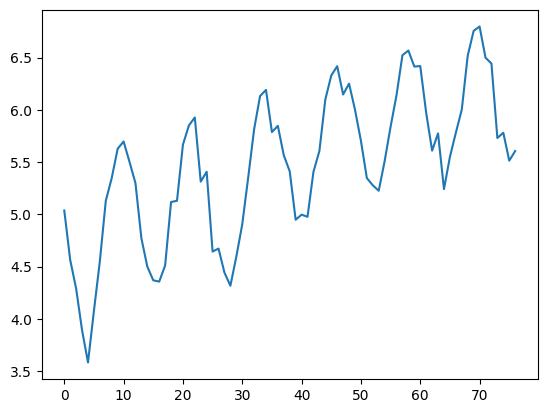

In [139]:
plt.plot(series_bc);

Графики компонент:

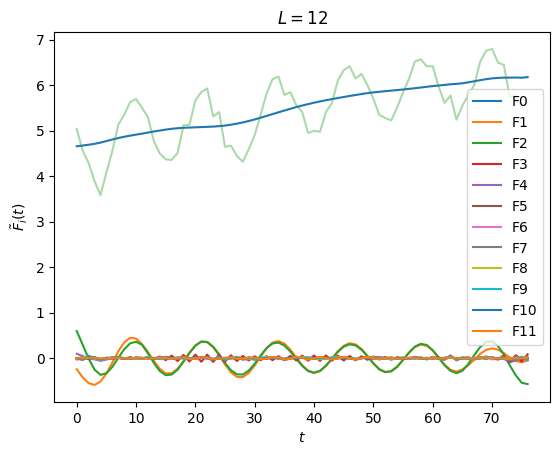

In [140]:
ssa_l12 = SSA(series_bc, 12)
ssa_l12.components_to_df().plot()
ssa_l12.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=12$");

Матрица корреляции для L = 12:

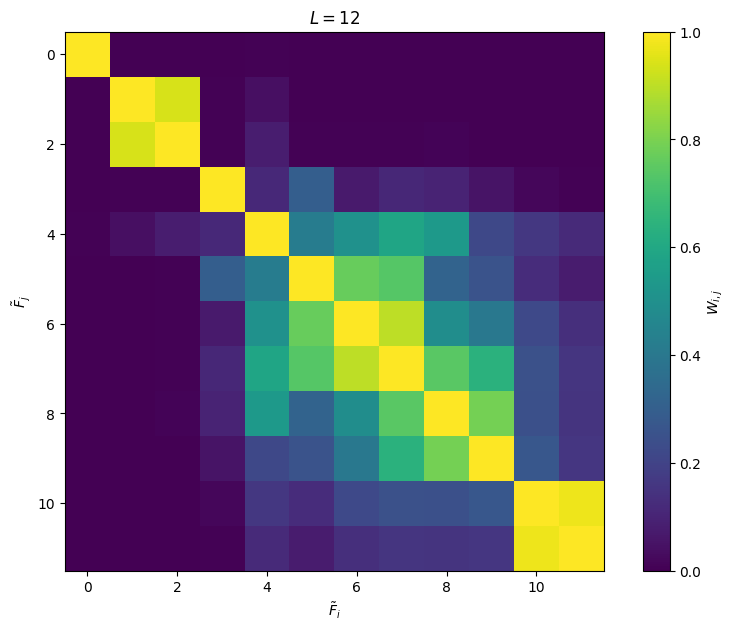

In [141]:
plt.figure(figsize=(10, 7))
ssa_l12 = SSA(series_bc, 12)
ssa_l12.plot_wcorr()
plt.title("$L=12$");

По полученной матрице для L = 12 заметен тренд (нулевая компонента), между собой коррелируют компоненты (1, 2); слабее, но явно (5, 6, 7). С учетом этого выполним реконструкцию составляющих ряда:

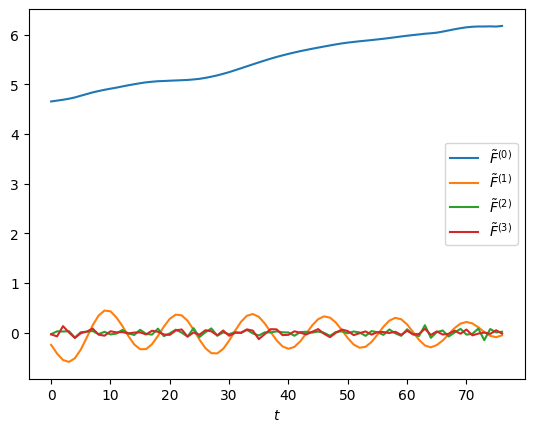

In [142]:
ssa_l12= SSA(series_bc, 12)
ssa_l12.reconstruct(0).plot() # тренд
ssa_l12.reconstruct(slice(1,2)).plot() # сезонность
ssa_l12.reconstruct([5,6,7]).plot() # сезонность
ssa_l12.reconstruct(slice(8,12)).plot() # шум
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)]);
plt.xlabel(r"$t$");

**Вывод: полученные графики подтверждают, что нулевая компонента - это тренд, компоненты 1 и 2 представляют собой сезонность, а компоненты (5,6,7) скорее похожи на составляющие шума.**